In [1]:
!pip install linearmodels pyblp -q

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import linearmodels as lm
from platform import python_version
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import quad
import pyblp
import scipy.optimize as optimize
import logging

print(python_version())

3.11.6


In [3]:
dist = np.random.default_rng(seed=228)

Reproduce PS3 Data

In [4]:
T = 600
J = 4
n_obs = T * J
beta_1 = 1
beta_2 = beta_3 = 4
beta_2_sd = beta_3_sd = 1
alpha = -2
gamma_0 = 0.5
gamma_1 = 0.25

x = abs(dist.standard_normal(size=n_obs))
w = abs(dist.standard_normal(size=n_obs))
T_id = np.repeat(np.arange(T), J)
J_id = np.tile(np.arange(J), T)
resid_ds = dist.multivariate_normal([0, 0], [[1, 0.25], [0.25, 1]], n_obs)
resid_d = resid_ds[:, 0]
resid_s = resid_ds[:, 1]

data = pd.DataFrame(
{
"market_ids": T_id,
"firm_ids": J_id,
"x": x,
"w": w,
"resid_d": resid_d,
"resid_s": resid_s
}
)

data['satellite'] = np.where((data['firm_ids'] == 0) | (data['firm_ids'] == 1), 1, 0)
data['wired'] = np.where((data['firm_ids'] == 2) | (data['firm_ids'] == 3), 1, 0)

In [5]:
Integration = pyblp.Integration("product", 9)

X1_formulation = pyblp.Formulation("0 + x + satellite + wired + prices")
X2_formulation = pyblp.Formulation("0 + satellite + wired") 
X3_formulation = pyblp.Formulation("1 + w") 

price_compute = pyblp.Simulation(
product_formulations=(X1_formulation, X2_formulation, X3_formulation),
product_data=data,
beta=[beta_1, beta_2, beta_3, alpha],
sigma=[[1, 0], [0, 1]],
gamma=[gamma_0, gamma_1],
costs_type="log",
xi_variance=1,
omega_variance=1,
correlation=0.25,
seed=228,
integration=Integration,
)

price_compute_r = price_compute.replace_endogenous()
product_data = pd.DataFrame(pyblp.data_to_dict(price_compute_r.product_data))

Initializing the simulation ...
Initialized the simulation after 00:00:00.

Dimensions:
 T    N     F     I     K1    K2    K3 
---  ----  ---  -----  ----  ----  ----
600  2400   4   48600   4     2     2  

Formulations:
       Column Indices:             0          1        2      3   
-----------------------------  ---------  ---------  -----  ------
 X1: Linear Characteristics        x      satellite  wired  prices
X2: Nonlinear Characteristics  satellite    wired                 
X3: Log Cost Characteristics       1          w                   

Nonlinear Coefficient True Values:
 Sigma:      satellite        wired    
---------  -------------  -------------
satellite  +1.000000E+00               
  wired    +0.000000E+00  +1.000000E+00

Beta True Values:
      x          satellite        wired         prices    
-------------  -------------  -------------  -------------
+1.000000E+00  +4.000000E+00  +4.000000E+00  -2.000000E+00

Gamma True Values:
      1              w      
-

In [6]:
np.random.seed(228)
num_draws = 2400  
beta_2_draws = dist.normal(4, 1, num_draws)
beta_3_draws = dist.normal(4, 1, num_draws)

def market_share(data, j):
    
    numerator = np.exp(beta_2_draws[:, None] * data['satellite'].values + 
                         data['wired'].values * beta_3_draws[:, None] +
                         alpha * data['prices'].values + 
                         beta_1 * data['x'].values + data['resid_d'].values)
    
    denominator = 1 + np.sum(numerator, axis=1) 
    return np.mean(numerator[:, j] / denominator) 

obs_mkt_share = data
obs_mkt_share = pd.merge(obs_mkt_share, product_data[['market_ids', 'firm_ids', 'prices', 'shares']], 
                       on=['market_ids', 'firm_ids'], how='left')

market_share_results = []
for market_id in obs_mkt_share['market_ids'].unique():
    market_data = obs_mkt_share[obs_mkt_share['market_ids'] == market_id]
    for j in market_data['firm_ids'].unique():
        share = market_share(market_data, j)
        
        market_share_results.append({
            'market_ids': market_id,
            'firm_ids': j,
            'market_share': share
        })
        
market_shares_df = pd.DataFrame(market_share_results)
market_shares_df.rename(columns={'market_share': 'obs_market_share'}, inplace=True)
market_shares_df
obs_mkt_share = obs_mkt_share.merge(market_shares_df, on=['market_ids', 'firm_ids'], how='left')
obs_mkt_share['obs_outside_mkt_share'] = 1 - obs_mkt_share.groupby(['market_ids'])['obs_market_share'].transform('sum')

obs_mkt_share['log_delta'] = np.log(obs_mkt_share['obs_market_share']/obs_mkt_share['obs_outside_mkt_share'])

other_x = obs_mkt_share.pivot(index="market_ids", columns="firm_ids", values="x")

for i in range(3):
    obs_mkt_share[f"x_comp_{i}"] = obs_mkt_share.apply(lambda row: other_x.loc[row["market_ids"]].drop(row["firm_ids"]).values[i], axis=1)

Estimate BLP: Demand-Supply with Optimal IV

In [7]:
demand_supply = pyblp.Problem(
    product_formulations=(
    X1_formulation,
    X2_formulation,
    X3_formulation,
    ),
    product_data=obs_mkt_share,
    integration=Integration,
    costs_type="log",
    add_exogenous=True,
)

result_demand_supply = demand_supply.solve(
    sigma=np.eye(2) * 0.5,
    beta=[None, None, None, -1],
)

Initializing the problem ...
Initialized the problem after 00:00:00.

Dimensions:
 T    N     F     I     K1    K2    K3    MD    MS 
---  ----  ---  -----  ----  ----  ----  ----  ----
600  2400   4   48600   4     2     2     3     2  

Formulations:
       Column Indices:             0          1        2      3   
-----------------------------  ---------  ---------  -----  ------
 X1: Linear Characteristics        x      satellite  wired  prices
X2: Nonlinear Characteristics  satellite    wired                 
X3: Log Cost Characteristics       1          w                   
Solving the problem ...

Nonlinear Coefficient Initial Values:
 Sigma:      satellite        wired    
---------  -------------  -------------
satellite  +5.000000E-01               
  wired    +0.000000E+00  +5.000000E-01

Beta Initial Values:
      x          satellite        wired         prices    
-------------  -------------  -------------  -------------
     NAN            NAN            NAN       -1.0

The model may be under-identified. The total number of unfixed parameters is 8, which is more than the total number of moments, 5. Consider checking whether instruments were properly specified when initializing the problem, and whether parameters were properly configured when solving the problem.



At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, this is not necessarily a problem. If the errors persist or seem to be impacting the optimization results, consider setting an error punishment or following any of the other suggestions below:
Encountered nonpositive marginal costs in a log-linear specification. This problem can sometimes be mitigated by bounding costs from below, choosing more reasonable initial parameter values, setting more conservative parameter bounds, or using a linear costs specification.
The fixed point computation of delta failed to converge. This problem can sometimes be mitigated by increasing the maximum number of fixed point iterations, increasing the fixed point tolerance, choosing more reasonable initial parameter values, setting more conservative parameter or share bounds, or using different iteration or optimization configurations.
Reverted problematic marginal costs.

In [8]:
demand_supply_iv = result_demand_supply.compute_optimal_instruments().to_problem()

result_demand_supply_iv = demand_supply_iv.solve(
    sigma=np.eye(2) * 0.5,
    beta=[None, None, None, -1],
)

Computing optimal instruments for theta ...
Computed optimal instruments after 00:00:02.

Optimal Instrument Results Summary:
Computation  Error Term  Fixed Point  Contraction
   Time        Draws     Iterations   Evaluations
-----------  ----------  -----------  -----------
 00:00:02        1          5964         5964    
Re-creating the problem ...
Re-created the problem after 00:00:00.

Dimensions:
 T    N     F     I     K1    K2    K3    MD    MS 
---  ----  ---  -----  ----  ----  ----  ----  ----
600  2400   4   48600   4     2     2     7     8  

Formulations:
       Column Indices:             0          1        2      3   
-----------------------------  ---------  ---------  -----  ------
 X1: Linear Characteristics        x      satellite  wired  prices
X2: Nonlinear Characteristics  satellite    wired                 
X3: Log Cost Characteristics       1          w                   
Solving the problem ...

Nonlinear Coefficient Initial Values:
 Sigma:      satellite   

Detected collinearity issues with [1] and at least one other column in ZS. To disable collinearity checks, set options.collinear_atol = options.collinear_rtol = 0.
Detected that the 2SLS weighting matrix is nearly singular with condition number +2.789039E+18. To disable singularity checks, set options.singular_tol = numpy.inf.



At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, this is not necessarily a problem. If the errors persist or seem to be impacting the optimization results, consider setting an error punishment or following any of the other suggestions below:
Encountered nonpositive marginal costs in a log-linear specification. This problem can sometimes be mitigated by bounding costs from below, choosing more reasonable initial parameter values, setting more conservative parameter bounds, or using a linear costs specification.
The fixed point computation of delta failed to converge. This problem can sometimes be mitigated by increasing the maximum number of fixed point iterations, increasing the fixed point tolerance, choosing more reasonable initial parameter values, setting more conservative parameter or share bounds, or using different iteration or optimization configurations.
Reverted problematic marginal costs.


At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, this is not necessarily a problem. If the errors persist or seem to be impacting the optimization results, consider setting an error punishment or following any of the other suggestions below:
The fixed point computation of delta failed to converge. This problem can sometimes be mitigated by increasing the maximum number of fixed point iterations, increasing the fixed point tolerance, choosing more reasonable initial parameter values, setting more conservative parameter or share bounds, or using different iteration or optimization configurations.

 1     00:00:04         2             9          9279         28346        0     -1.694845E+03                 +4.889573E+03  +7.467710E-01, +5.548667E-01, -2.282048E+00

At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, th


At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, this is not necessarily a problem. If the errors persist or seem to be impacting the optimization results, consider setting an error punishment or following any of the other suggestions below:
The fixed point computation of delta failed to converge. This problem can sometimes be mitigated by increasing the maximum number of fixed point iterations, increasing the fixed point tolerance, choosing more reasonable initial parameter values, setting more conservative parameter or share bounds, or using different iteration or optimization configurations.

 1     00:00:04         3            19          12599        38298        0     -1.694845E+03                 +3.111022E+03  +7.467710E-01, +5.548667E-01, -2.282048E+00

At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, th


At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, this is not necessarily a problem. If the errors persist or seem to be impacting the optimization results, consider setting an error punishment or following any of the other suggestions below:
The fixed point computation of delta failed to converge. This problem can sometimes be mitigated by increasing the maximum number of fixed point iterations, increasing the fixed point tolerance, choosing more reasonable initial parameter values, setting more conservative parameter or share bounds, or using different iteration or optimization configurations.

 1     00:00:04         4            29          12584        38266        0     -3.901884E+03                 +3.111022E+03  +7.467710E-01, +5.548667E-01, -2.282048E+00

At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, th


At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, this is not necessarily a problem. If the errors persist or seem to be impacting the optimization results, consider setting an error punishment or following any of the other suggestions below:
The fixed point computation of delta failed to converge. This problem can sometimes be mitigated by increasing the maximum number of fixed point iterations, increasing the fixed point tolerance, choosing more reasonable initial parameter values, setting more conservative parameter or share bounds, or using different iteration or optimization configurations.

 1     00:00:03         5            39          7612         23354        0     +2.290745E+03                 +3.111022E+03  +7.467710E-01, +5.548667E-01, -2.282048E+00

At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, th


At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, this is not necessarily a problem. If the errors persist or seem to be impacting the optimization results, consider setting an error punishment or following any of the other suggestions below:
The fixed point computation of delta failed to converge. This problem can sometimes be mitigated by increasing the maximum number of fixed point iterations, increasing the fixed point tolerance, choosing more reasonable initial parameter values, setting more conservative parameter or share bounds, or using different iteration or optimization configurations.

 1     00:00:03         5            49          10921        33271        0     -3.901884E+03                 +4.889482E+03  +7.467710E-01, +5.548667E-01, -2.282048E+00

At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, th


At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, this is not necessarily a problem. If the errors persist or seem to be impacting the optimization results, consider setting an error punishment or following any of the other suggestions below:
The fixed point computation of delta failed to converge. This problem can sometimes be mitigated by increasing the maximum number of fixed point iterations, increasing the fixed point tolerance, choosing more reasonable initial parameter values, setting more conservative parameter or share bounds, or using different iteration or optimization configurations.

 1     00:00:04         5            58          12585        38263        0     -5.680435E+03                 +3.111022E+03  +7.467710E-01, +5.548667E-01, -2.282048E+00

At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, th

Detected that the estimated covariance matrix of aggregate GMM moments is nearly singular with condition number +6.526092E+16. To disable singularity checks, set options.singular_tol = numpy.inf.



The fixed point computation of delta failed to converge. This problem can sometimes be mitigated by increasing the maximum number of fixed point iterations, increasing the fixed point tolerance, choosing more reasonable initial parameter values, setting more conservative parameter or share bounds, or using different iteration or optimization configurations.

Computed results after 00:00:25.

Problem Results Summary:
GMM     Objective      Projected    Reduced Hessian  Reduced Hessian  Clipped  Weighting Matrix
Step      Value      Gradient Norm  Min Eigenvalue   Max Eigenvalue   Shares   Condition Number
----  -------------  -------------  ---------------  ---------------  -------  ----------------
 1    -5.680435E+03  +3.111022E+03   -6.210888E+10    +5.735350E+10      0      +1.039033E+18  

Starting optimization ...


At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, this is not necessarily a prob


At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, this is not necessarily a problem. If the errors persist or seem to be impacting the optimization results, consider setting an error punishment or following any of the other suggestions below:
Encountered nonpositive marginal costs in a log-linear specification. This problem can sometimes be mitigated by bounding costs from below, choosing more reasonable initial parameter values, setting more conservative parameter bounds, or using a linear costs specification.
The fixed point computation of delta failed to converge. This problem can sometimes be mitigated by increasing the maximum number of fixed point iterations, increasing the fixed point tolerance, choosing more reasonable initial parameter values, setting more conservative parameter or share bounds, or using different iteration or optimization configurations.
Reverted problematic marginal costs.


At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, this is not necessarily a problem. If the errors persist or seem to be impacting the optimization results, consider setting an error punishment or following any of the other suggestions below:
The fixed point computation of delta failed to converge. This problem can sometimes be mitigated by increasing the maximum number of fixed point iterations, increasing the fixed point tolerance, choosing more reasonable initial parameter values, setting more conservative parameter or share bounds, or using different iteration or optimization configurations.
Encountered nonpositive marginal costs in a log-linear specification. This problem can sometimes be mitigated by bounding costs from below, choosing more reasonable initial parameter values, setting more conservative parameter bounds, or using a linear costs specification.
Reverted problematic marginal costs.


At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, this is not necessarily a problem. If the errors persist or seem to be impacting the optimization results, consider setting an error punishment or following any of the other suggestions below:
Encountered nonpositive marginal costs in a log-linear specification. This problem can sometimes be mitigated by bounding costs from below, choosing more reasonable initial parameter values, setting more conservative parameter bounds, or using a linear costs specification.
The fixed point computation of delta failed to converge. This problem can sometimes be mitigated by increasing the maximum number of fixed point iterations, increasing the fixed point tolerance, choosing more reasonable initial parameter values, setting more conservative parameter or share bounds, or using different iteration or optimization configurations.
Reverted problematic marginal costs.


At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, this is not necessarily a problem. If the errors persist or seem to be impacting the optimization results, consider setting an error punishment or following any of the other suggestions below:
Encountered nonpositive marginal costs in a log-linear specification. This problem can sometimes be mitigated by bounding costs from below, choosing more reasonable initial parameter values, setting more conservative parameter bounds, or using a linear costs specification.
The fixed point computation of delta failed to converge. This problem can sometimes be mitigated by increasing the maximum number of fixed point iterations, increasing the fixed point tolerance, choosing more reasonable initial parameter values, setting more conservative parameter or share bounds, or using different iteration or optimization configurations.
Reverted problematic marginal costs.

Detected that the estimated covariance matrix of aggregate GMM moments is nearly singular with condition number +2.227919E+16. To disable singularity checks, set options.singular_tol = numpy.inf.
Detected that the estimated covariance matrix of aggregate GMM moments is nearly singular with condition number +3.199804E+16. To disable singularity checks, set options.singular_tol = numpy.inf.


Estimate Marginal Costs

In [9]:
mc = result_demand_supply_iv.compute_costs()

Computing marginal costs ...
Finished after 00:00:00.



In [10]:
pre_prices_avg_p = obs_mkt_share.groupby('firm_ids', as_index=False)['prices'].mean()
pre_prices_avg_p

,firm_ids,prices
0,0,4.269134
1,1,4.390294
2,2,3.988726
3,3,3.828221


In [11]:
pre_cs = result_demand_supply_iv.compute_consumer_surpluses(obs_mkt_share['prices'])
print(pre_cs.mean(axis= 0))

Computing consumer surpluses with the equation that assumes away nonlinear income effects ...
Finished after 00:00:00.

[0.90064756]


Firms 1 and 2 Merge

In [12]:
merger_1_2 = obs_mkt_share.copy()
merger_1_2['merger_ids'] = merger_1_2['firm_ids'].replace(0, 1)

In [13]:
merger_1_2_prices = result_demand_supply_iv.compute_prices(
    firm_ids=merger_1_2['merger_ids'],
    costs=mc
)

Solving for equilibrium prices ...
Finished after 00:00:02.



In [14]:
print(merger_1_2_prices.reshape((600, 4)).mean(axis= 0))

[4.57485933 4.70443641 4.00266076 3.83856924]


Firms 1 and 3 Merge

In [15]:
merger_1_3 = obs_mkt_share.copy()
merger_1_3['merger_ids'] = merger_1_3['firm_ids'].replace(2, 0)

In [16]:
merger_1_3_prices = result_demand_supply_iv.compute_prices(
    firm_ids=merger_1_3['merger_ids'],
    costs=mc
)

Solving for equilibrium prices ...
Finished after 00:00:01.



In [17]:
print(merger_1_3_prices.reshape((600, 4)).mean(axis= 0))

[4.44146688 4.40357363 4.14917182 3.8388698 ]


Firms 1 and 2 Merge with 15% Cost Savings

In [18]:
mc_085 = mc.copy()
mc_085 = mc_085.reshape(600, 4)
mc_085[:, :2] *= 0.85
mc_085 = mc_085.reshape(2400, 1)

In [19]:
merger_1_2_prices_085 = result_demand_supply_iv.compute_prices(
    firm_ids=merger_1_2['merger_ids'],
    costs=mc_085
)

Solving for equilibrium prices ...
Finished after 00:00:02.



In [20]:
print(merger_1_2_prices_085.reshape((600, 4)).mean(axis= 0))

[4.10546033 4.21560085 3.99576907 3.83118665]


Firms 1 and 2 Merge with 15% Cost Savings - Consumer Surplus

In [21]:
changed_cs = result_demand_supply_iv.compute_consumer_surpluses(merger_1_2_prices_085)
print(changed_cs.mean(axis = 0))

Computing consumer surpluses with the equation that assumes away nonlinear income effects ...
Finished after 00:00:00.

[0.87153881]


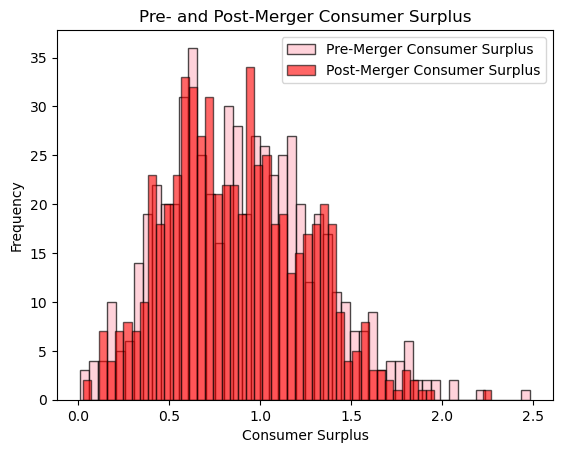

In [22]:
plt.hist(pre_cs, bins=50, alpha=0.7, label='Pre-Merger Consumer Surplus', edgecolor='black', color = 'pink')
plt.hist(changed_cs, bins=50, alpha=0.6, label='Post-Merger Consumer Surplus', edgecolor='black', color = 'red')

plt.title("Pre- and Post-Merger Consumer Surplus")
plt.xlabel("Consumer Surplus")
plt.ylabel("Frequency")

plt.legend()
plt.show()